In [2]:
from paper_plots import plot_hp_convergence
import numpy as np
from domains import Waveguide, ScattererShape, ScattererType
from FEM_solution import FEM_solution


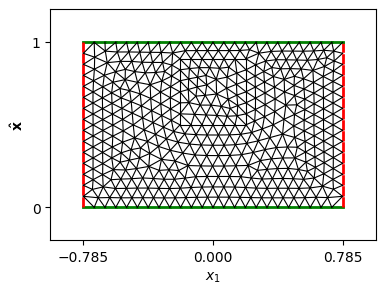

In [3]:
kappa_e = 8.
lambda_e = 2*np.pi/kappa_e
R = lambda_e
H = 1.

c = (0,0.7*H)
Domain = Waveguide(R=R,H=H)

rad = 0.1*H


scatterer_shape = ScattererShape.RECTANGLE
scatterer_type = ScattererType.PENETRABLE

#Domain.add_scatterer( ScattererShape.CIRCLE, ScattererType.SOUND_SOFT, (c, rad))
Domain.add_scatterer( scatterer_shape=scatterer_shape, scatterer_type=scatterer_type, params=(c, 4*rad, 4*rad))

Domain.generate_mesh(h_max=H/15)
Domain.plot_mesh()

In [4]:
Ny = 50
Nx = 10*Ny
x = np.linspace(-R,R,Nx)
y = np.linspace(0,H,Ny)
X, Y = np.meshgrid(x,y)
t = 0
kappa = 8.0
N = 4 + 20j
#N = 4

Z = FEM_solution( R=R, H=H, params={"c":c, "height" : 2*rad, "width" : 2*rad}, scatterer_shape=scatterer_shape, scatterer_type=scatterer_type, 
                 n=t,k_e=kappa,k_i= np.sqrt(kappa), X=X, Y=Y, delta_PML=0.5*R, alpha=0.5*(4+2*1j))

NDOF: 41691


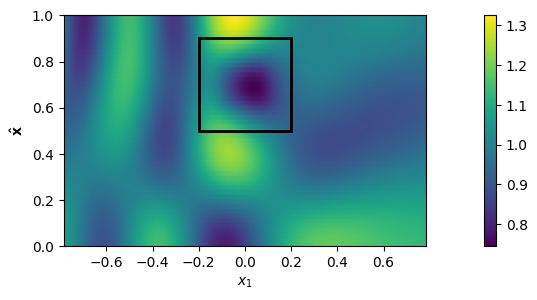

In [5]:
Domain.plot_field(X, Y, np.abs(Z))

In [6]:
from Trefft_tools import  TrefftzSpace, AssembleMatrix, AssembleRHS, Assemble_blockMatrix
Nth = 13
th_0 = np.e/np.pi
V = TrefftzSpace(Domain=Domain, DOF_per_element=Nth, kappa=kappa, n= {"Omega_i" : N, "Omega_e" : 1}, th0=th_0 )
N_modes = 15 #Number of modes for the DtN map
# "UWVF" parameters
a = 0.5
b = 0.5
d_1 = 0.5
d_2 = 0.5
# A = AssembleMatrix(V=V, Edges=Domain.Edges, H=H, Np=N_modes, a=a, b=b, d_1=d_1, d_2=d_2)
A = Assemble_blockMatrix(V=V, Edges=Domain.Edges, th_0=th_0, H=H, k=kappa, N_p=Nth, a=a, b=b, d_1=d_1, d_2=d_2, N_DtN=N_modes)

NDOF = A.shape[0]
print(f'{NDOF} degrees of freedom.\n Matrix with {np.count_nonzero(A.toarray())} non-zero entries from a total of {NDOF**2}.\n "fullness" ratio: {np.count_nonzero(A.toarray())/NDOF**2 * 100 : .2f}%')

10452 degrees of freedom.
 Matrix with 601302 non-zero entries from a total of 109244304.
 "fullness" ratio:  0.55%


In [53]:
B = AssembleRHS(V, Domain.Edges, kappa_e, H, d_2=d_2, t = t)
from Trefft_tools import TrefftzFunction
#this should be a "solve system"
from scipy.sparse.linalg import spsolve 
A = A.tocsc()
DOFs = spsolve(A,B)
f = TrefftzFunction(V,DOFs)

In [54]:
u_Trefft =  np.reshape([ f(x_, y_) for x_, y_ in zip( X.ravel(), Y.ravel()) ], [Ny,Nx])


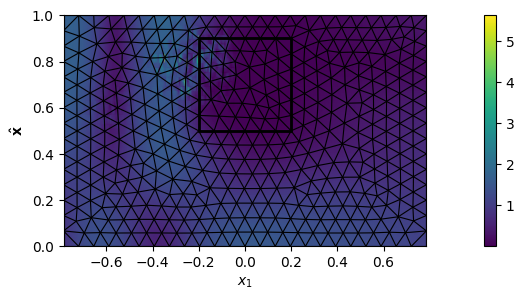

In [56]:
Domain.plot_field(X,Y,np.abs(u_Trefft), show_edges=True)


The relative error is:  6.73e-01


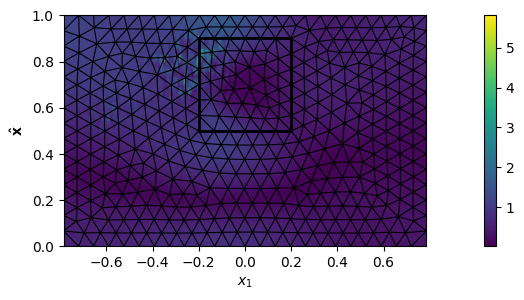

In [57]:
Domain.plot_field(X,Y,np.abs(u_Trefft - Z), show_edges=True)
print(f'The relative error is: {Domain.L2_norm(X,Y,np.abs(u_Trefft - Z))/Domain.L2_norm(X,Y,np.abs(Z)) : .2e}')